In [14]:
from openai.types.audio import TranscriptionVerbose, TranscriptionWord
from typing import List, Dict, Optional, Tuple, Union
from dataclasses import dataclass
import pandas as pd
from Levenshtein import distance
import json
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
from align import AlignedWord, deserialize_transcription_from_file, convert_file_times_to_absolute_times, word_similarity
import copy

In [15]:
TITLE = "LA BOHÈME"
FILE_PREFIX = "boheme"
SECONDARY_COLOR_X11 = "LightSteelBlue"
LANGUAGE_ID = "it"
START_IDX = 1
END_IDX = 32

CHARACTER_NAMES = [
    "Rodolfo", "Mimì", "Marcello", "Musetta", "Schaunard", "Colline", "Benoît", "Alcindoro", "Parpignol", "A customs Sergeant", "Students", "working girls", "townsfolk", "shopkeepers", "street-vendors", "soldiers", "waiters", "children"
]

# for every character, ensure that the uppercase and lowercase versions are in the list
CHARACTER_NAMES = [*CHARACTER_NAMES, *[name.lower() for name in CHARACTER_NAMES], *[name.upper() for name in CHARACTER_NAMES]]

In [16]:
def plot_length_ratios(lines_de, lines_en):
    length_ratios = [len(de) / len(en) for de, en in zip(lines_de, lines_en)]
    # print a chart of length_ratios

    # Plot the length ratios
    plt.figure(figsize=(10, 5))
    plt.plot(length_ratios)
    plt.title(f'Length Ratios of {LANGUAGE_ID} and en Lines')
    plt.xlabel('Line Number')
    plt.ylabel('Length Ratio')
    plt.grid(True)
    plt.show()

    # Find the index where the length ratios start to deviate significantly
    threshold = 1.5  # Adjust this threshold as needed
    deviation_index = next((i for i, ratio in enumerate(length_ratios) if abs(ratio - 1) > threshold), None)

    if deviation_index is not None:
        print(f"Significant deviation starts at line {deviation_index}")
        print(f"{LANGUAGE_ID} line: {lines_de[deviation_index]}")
        print(f"en line: {lines_en[deviation_index]}")
    else:
        print("No significant deviation found.")

def pair_libretto_lines_simple(german_text, english_text):
    lines_de = german_text.split("\n\n")
    lines_en = english_text.split("\n\n")

    # Remove empty lines
    lines_de = [line for line in lines_de if line.strip()]
    lines_en = [line for line in lines_en if line.strip()]

    print(len(lines_de), len(lines_en))

    # print the average length of each german line
    print(sum(len(line) for line in lines_de) / len(lines_de))
    print(sum(len(line) for line in lines_en) / len(lines_en))

    print(len(lines_de), len(lines_en))

    plot_length_ratios(lines_de, lines_en)

    return list(zip(lines_de, lines_en))

763 763
58.25294888597641
60.46657929226737
763 763


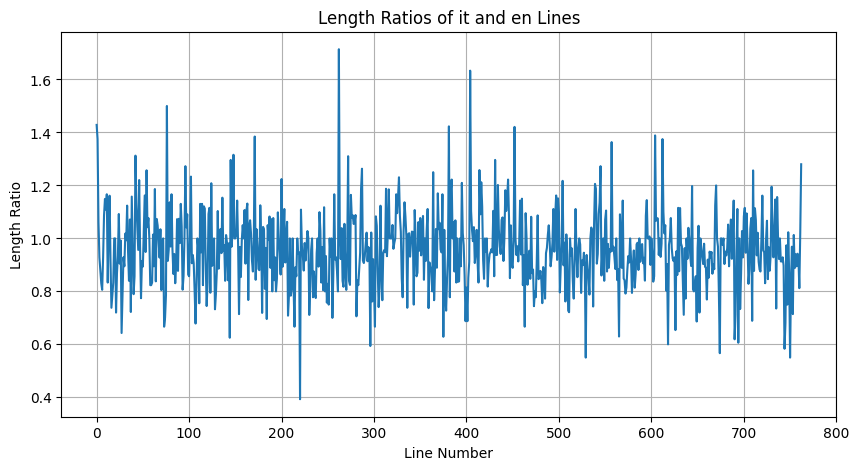

No significant deviation found.


In [17]:
with open(f"libretti/{FILE_PREFIX}_{LANGUAGE_ID}.txt", "r", encoding="utf-8") as f:
    libretto_de = f.read()

with open(f"libretti/{FILE_PREFIX}_en.txt", "r", encoding="utf-8") as f:
    libretto_en = f.read()

pairs = pair_libretto_lines_simple(libretto_de, libretto_en)

Splitting pair 223
Splitting pair 226
Splitting pair 229
Splitting pair 268
Splitting pair 726
Final number of pairs: 768
First pair: ('ATTO PRIMO', 'ACT ONE')
Last pair: ('RODOLFO\nMimì!...Mimì!...Mimì!...', 'RODOLFO\nMimì! Mimì! Mimì!')


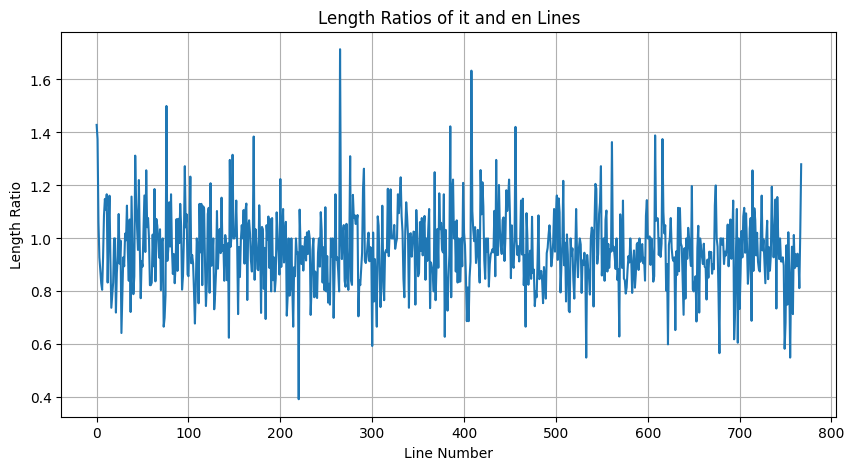

No significant deviation found.


In [18]:
def is_safe_split_point(lines, index):
    """Check if splitting at this line index would break any parentheses pairs"""
    text_before = '\n'.join(lines[:index])
    open_count = text_before.count('(') - text_before.count(')')
    return open_count == 0

def find_safe_split_point(lines):
    """Find the closest safe split point to the middle"""
    mid = len(lines) // 2
    
    # Try points progressively further from the middle
    for offset in range(len(lines)):
        # Try point after middle
        if mid + offset < len(lines):
            if is_safe_split_point(lines, mid + offset):
                return mid + offset
        # Try point before middle
        if mid - offset >= 1:  # Ensure we don't split at 0
            if is_safe_split_point(lines, mid - offset):
                return mid - offset
    
    # If no safe point found, return middle as fallback
    return mid

def split_long_pairs(pairs, max_length=15):
    need_another_pass = True
    while need_another_pass:
        need_another_pass = False
        i = 0
        while i < len(pairs):
            de, en = pairs[i]
            de_lines = de.split("\n")
            en_lines = en.split("\n")
            
            if len(de_lines) > max_length:
                need_another_pass = True
                print(f"Splitting pair {i}")
                
                # Find safe split point based on German text
                split_point = find_safe_split_point(de_lines)
                
                # Split both German and English at this point
                pairs[i] = (
                    "\n".join(de_lines[:split_point]),
                    "\n".join(en_lines[:split_point])
                )
                pairs.insert(i+1, (
                    "\n".join(de_lines[split_point:]),
                    "\n".join(en_lines[split_point:])
                ))
            i += 1

    return pairs

# Apply the splitting
pairs = split_long_pairs(pairs)

# print the number of pairs
print(f"Final number of pairs: {len(pairs)}")

# print the first pair
print("First pair:", pairs[0])

# print the last pair
print("Last pair:", pairs[-1])

plot_length_ratios([pair[0] for pair in pairs], [pair[1] for pair in pairs])

In [19]:
def align_transcription_with_libretto(
    transcription: List[TranscriptionWord],
    libretto: List[str],
    ground_truth_timestamps: Dict[int, float] = None,  # Maps libretto index to timestamp
    ground_truth_duration: float = 1.0,
    min_similarity: float = 0.5
) -> List[AlignedWord]:
    """
    Align transcription with libretto using dynamic programming.
    Returns list of aligned words with timing information where available.
    Assumes ground truth words are 1 second in duration.
    
    Args:
        transcription: List of TranscriptionWord objects
        libretto: List of ground truth words
        ground_truth_timestamps: Dictionary mapping libretto indices to known timestamps
        min_similarity: Minimum similarity score to consider words as matching
    """
    
    ground_truth_timestamps = ground_truth_timestamps or {}
    
    # Initialize scoring matrix
    m, n = len(transcription), len(libretto)
    score_matrix = [[0.0] * (n + 1) for _ in range(m + 1)]
    backtrack = [[None] * (n + 1) for _ in range(m + 1)]
    
    gap_penalty = -0.5
    timestamp_bonus = 2.0  # Bonus score for matching known timestamps
    
    # Fill scoring matrix
    for i in range(m + 1):
        score_matrix[i][0] = i * gap_penalty
    for j in range(n + 1):
        score_matrix[0][j] = j * gap_penalty
        
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            similarity = word_similarity(transcription[i-1].word, libretto[j-1])
            
            # Add bonus if this alignment matches a known timestamp
            if j-1 in ground_truth_timestamps:
                known_time = ground_truth_timestamps[j-1]
                trans_time = transcription[i-1].start
                # If transcription time is close to known time, add bonus
                if abs(known_time - trans_time) < 1.0:  # Within 1 second
                    similarity += timestamp_bonus
            
            match_score = score_matrix[i-1][j-1] + similarity
            delete_score = score_matrix[i-1][j] + gap_penalty
            insert_score = score_matrix[i][j-1] + gap_penalty
            
            best_score = max(match_score, delete_score, insert_score)
            score_matrix[i][j] = best_score
            
            if best_score == match_score:
                backtrack[i][j] = 'match'
            elif best_score == delete_score:
                backtrack[i][j] = 'delete'
            else:
                backtrack[i][j] = 'insert'
    
    # Backtrack to build alignment
    aligned_words: List[AlignedWord] = []
    i, j = m, n
    
    while i > 0 or j > 0:
        if i > 0 and j > 0 and backtrack[i][j] == 'match':
            similarity = word_similarity(transcription[i-1].word, libretto[j-1])
            
            # If we have a ground truth timestamp for this word
            if j-1 in ground_truth_timestamps:
                start_time = ground_truth_timestamps[j-1]
                aligned_words.append(AlignedWord(
                    word=libretto[j-1],
                    start=start_time,
                    end=start_time + 1.0  # Assume 1 second duration
                ))
            elif similarity >= min_similarity:
                # Regular good match - use transcription timing
                aligned_words.append(AlignedWord(
                    word=libretto[j-1],
                    start=transcription[i-1].start,
                    end=transcription[i-1].end
                ))
            else:
                # Poor match - include word without timing
                aligned_words.append(AlignedWord(
                    word=libretto[j-1],
                    start=None,
                    end=None
                ))
            i -= 1
            j -= 1
        elif i > 0 and (j == 0 or backtrack[i][j] == 'delete'):
            i -= 1
        else:
            # For inserted words, if we have a ground truth timestamp, use it
            start_time = ground_truth_timestamps.get(j-1)
            if start_time is not None:
                aligned_words.append(AlignedWord(
                    word=libretto[j-1],
                    start=start_time,
                    end=start_time + ground_truth_duration
                ))
            else:
                aligned_words.append(AlignedWord(
                    word=libretto[j-1],
                    start=None,
                    end=None
                ))
            j -= 1
    
    return list(reversed(aligned_words))

def enforce_monotonicity(aligned_words: List[AlignedWord]) -> List[AlignedWord]:
    """
    Enforce temporal monotonicity in aligned words by adjusting timestamps.
    """
    result = copy.deepcopy(aligned_words)
    last_end_time = float('-inf')
    
    for word in result:
        if word.start is not None:
            if word.start < last_end_time:
                # Adjust timing to maintain monotonicity
                duration = word.end - word.start
                word.start = last_end_time
                word.end = last_end_time + duration
            last_end_time = word.end
    
    return result

def interpolate_word_timings(
    aligned_words: List[AlignedWord],
    max_interpolation_window: float = 8.0
) -> List[AlignedWord]:
    """
    Interpolate timing for words between known timestamps within a maximum window.
    
    Args:
        aligned_words: List of AlignedWord objects
        max_interpolation_window: Maximum time window in seconds for interpolation
        
    Returns:
        New list of AlignedWord objects with interpolated timings
    """
    result = copy.deepcopy(aligned_words)
    
    # First pass: identify sequences of words to interpolate
    sequences = []
    current_sequence = []
    last_known_end = None
    
    for i, word in enumerate(result):
        if word.start is not None and word.end is not None:
            # Found a word with known timing
            if current_sequence and last_known_end is not None:
                # Check if this word is within the interpolation window
                if word.start - last_known_end <= max_interpolation_window:
                    # Add the current word as the end anchor of the sequence
                    current_sequence.append(i)
                    sequences.append(current_sequence)
                current_sequence = []
            last_known_end = word.end
            current_sequence = [i]  # Start new sequence with this word
        elif current_sequence:
            # Add word without timing to current sequence
            current_sequence.append(i)
    
    # Second pass: perform interpolation for each valid sequence
    for sequence in sequences:
        if len(sequence) < 2:
            continue
        
        start_idx = sequence[0]
        end_idx = sequence[-1]
        start_word = result[start_idx]
        end_word = result[end_idx]
        
        # Skip if either anchor point doesn't have timing
        if (start_word.start is None or start_word.end is None or 
            end_word.start is None or end_word.end is None):
            continue
        
        # Calculate time distribution
        total_words = len(sequence)
        if total_words <= 1:
            continue
            
        # For the first word in sequence, keep its original end time
        # For the last word in sequence, keep its original start time
        total_time = end_word.start - start_word.end
        words_to_interpolate = total_words - 1  # excluding first word
        
        if words_to_interpolate <= 0:
            continue
            
        # Calculate time per word
        time_per_word = total_time / words_to_interpolate
        
        # Set timings for words in between
        current_time = start_word.end
        for i in range(1, len(sequence)):
            idx = sequence[i]
            word = result[idx]
            
            if i == len(sequence) - 1:
                # Last word in sequence - keep its original timing
                word.start = end_word.start
                word.end = end_word.end
            else:
                # Interpolated word
                word.start = current_time
                word.end = current_time + time_per_word
                current_time += time_per_word
    
    return result

from typing import Dict, List

def parse_timestamp_and_phrase(
    timestamp_str: str,
    phrase: str,
    libretto: List[str]
) -> Dict[int, float]:
    """
    Convert a human-readable timestamp and phrase into ground truth timestamp dict.
    
    Args:
        timestamp_str: Timestamp in format "H:M:S" or "M:S" or "S"
        phrase: Text phrase to locate in libretto
        libretto: List of ground truth words
    
    Returns:
        Dictionary mapping libretto index to timestamp in seconds
    
    Raises:
        ValueError: If phrase not found or found multiple times, or invalid timestamp
    """
    # Parse timestamp to seconds
    def parse_timestamp(ts: str) -> float:
        parts = ts.split(':')
        if len(parts) == 3:  # H:M:S
            h, m, s = map(float, parts)
            return h * 3600 + m * 60 + s
        elif len(parts) == 2:  # M:S
            m, s = map(float, parts)
            return m * 60 + s
        elif len(parts) == 1:  # S
            return float(parts[0])
        else:
            raise ValueError(f"Invalid timestamp format: {ts}")
    
    # Convert phrase to list of words and clean
    phrase_words = phrase.lower().split()
    
    # Find all occurrences of the phrase in libretto
    matches = []
    for i in range(len(libretto) - len(phrase_words) + 1):
        window = libretto[i:i + len(phrase_words)]
        if [w.lower() for w in window] == phrase_words:
            matches.append(i)
    
    # Verify unique match
    if len(matches) == 0:
        raise ValueError(f"Phrase '{phrase}' not found in libretto")
    if len(matches) > 1:
        raise ValueError(
            f"Phrase '{phrase}' found multiple times in libretto at indices {matches}"
        )
    
    # Convert timestamp to seconds
    start_time = parse_timestamp(timestamp_str)
    
    # Return dict mapping the starting index to the timestamp
    return {matches[0]: start_time}

In [20]:
# Load transcriptions
transcriptions: List[TranscriptionVerbose] = []
for i in range(START_IDX, END_IDX):
    i_string = str(i).zfill(2)
    transcription = deserialize_transcription_from_file(f'{FILE_PREFIX}_transcribed/{i_string}.json')
    transcriptions.append(transcription)

transcriptions = convert_file_times_to_absolute_times(transcriptions)

all_words: List[TranscriptionWord] = [word for transcription in transcriptions for word in transcription.words]

# Load libretto
with open(f'libretti/{FILE_PREFIX}_{LANGUAGE_ID}.txt', 'r') as f:
    libretto = f.read()

libretto = libretto.split()

markers = [
    ("1:48:35", "Coraggio."),
    ("1:48:42", "Mimì!...Mimì!...Mimì!...")
]

ground_truth = {}
for timestamp, phrase in markers:
    ground_truth.update(parse_timestamp_and_phrase(timestamp, phrase, libretto))

# Align texts
aligned_words = align_transcription_with_libretto(
    transcription=all_words,
    libretto=libretto,
    ground_truth_timestamps=ground_truth,
    ground_truth_duration=5,
    min_similarity=0.3
)

# enforce monotonicity
# aligned_words = enforce_monotonicity(aligned_words)

# give the percentage of AlignedWords that have a start and end time
percentage_aligned = len([word for word in aligned_words if word.start is not None and word.end is not None]) / len(aligned_words)
print(f"Percentage of aligned words: {percentage_aligned}")

Percentage of aligned words: 0.3671161967034464


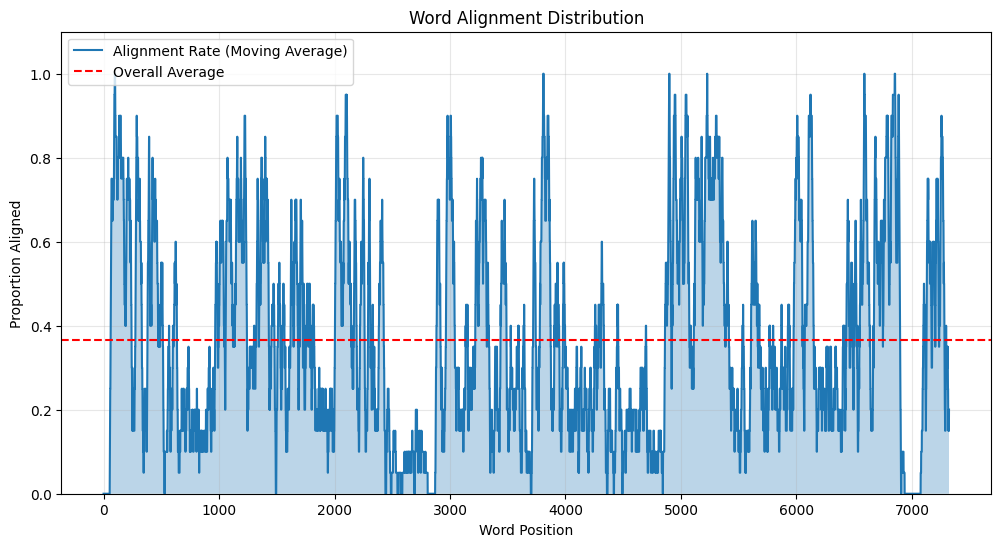

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from typing import List

def detect_low_alignment(smoothed: np.ndarray, overall_avg: float, threshold: float = 0.2, window: int = 500) -> List[tuple]:
    low_periods = []
    current_start = None
    
    for i, val in enumerate(smoothed):
        if val < (overall_avg - threshold):
            if current_start is None:
                current_start = i
        elif current_start is not None:
            if i - current_start >= window:
                low_periods.append((current_start, i))
            current_start = None
            
    if current_start is not None and len(smoothed) - current_start >= window:
        low_periods.append((current_start, len(smoothed)))
        
    return low_periods

def plot_aligned_words(aligned_words: List[AlignedWord]):
    aligned = [i.start is not None and i.end is not None for i in aligned_words]
    aligned_int = [1 if x else 0 for x in aligned]
    overall_avg = np.mean(aligned_int)

    window_size = 20
    smoothed = np.convolve(aligned_int, np.ones(window_size)/window_size, mode='valid')

    low_periods = detect_low_alignment(smoothed, overall_avg)

    plt.figure(figsize=(12, 6))
    plt.plot(smoothed, label='Alignment Rate (Moving Average)')
    plt.axhline(y=overall_avg, color='r', linestyle='--', label='Overall Average')
    
    for start, end in low_periods:
        plt.axvspan(start, end, color='red', alpha=0.2)
    
    plt.fill_between(range(len(smoothed)), smoothed, alpha=0.3)
    plt.ylim(0, 1.1)
    plt.xlabel('Word Position')
    plt.ylabel('Proportion Aligned')
    plt.title('Word Alignment Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    if low_periods:
        print(f"Warning: Found {len(low_periods)} periods of low alignment (>500 words below average)")
        for start, end in low_periods:
            print(f"Low alignment period: words {start} to {end}")

            # print the first 20 words of the low alignment period
            print(f"First 20 words: {[aligned_words[i].word for i in range(start, min(start+20, end))]}")
    
    plt.show()

plot_aligned_words(aligned_words)

In [22]:
# write aligned words to csv

def write_aligned_words_to_csv(aligned_words: List[AlignedWord], filename: str):
    # Convert list of AlignedWord to list of dictionaries
    data = [{'word': w.word, 'start': w.start, 'end': w.end} for w in aligned_words]
    
    # Create DataFrame and write to CSV
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)

def read_edited_aligned_words_from_csv(filename: str) -> List[AlignedWord]:
    # Read CSV into DataFrame
    df = pd.read_csv(filename)

    # Convert DataFrame to list of AlignedWord
    aligned_words = [AlignedWord(row['word'], row['start'], row['end']) for _, row in df.iterrows()]

    # replace nans with None
    for word in aligned_words:
        if pd.isna(word.start):
            word.start = None
        if pd.isna(word.end):
            word.end = None

    return aligned_words

write_aligned_words_to_csv(aligned_words, f'aligned_words_{FILE_PREFIX}.csv')

In [23]:
# read aligned words from csv
aligned_words = read_edited_aligned_words_from_csv(f'aligned_words_{FILE_PREFIX}.csv')

In [24]:
aligned_words = interpolate_word_timings(aligned_words, max_interpolation_window=20)

# give the percentage of AlignedWords that have a start and end time
percentage_aligned = len([word for word in aligned_words if word.start is not None and word.end is not None]) / len(aligned_words)
print(f"Percentage of aligned words: {percentage_aligned}")

Percentage of aligned words: 0.9125459746628525


In [25]:
from moviepy.editor import (
    AudioFileClip, TextClip, CompositeVideoClip, 
    ColorClip, concatenate_audioclips, VideoClip
)
from typing import List, Tuple, Optional, Dict
import numpy as np
import imageio
from tqdm import tqdm
from dataclasses import dataclass

@dataclass
class VideoConfig:
    font_name: str = "Arial"
    font_size: int = 40
    text_1_color: str = "AliceBlue"
    text_2_color: str = "LightGoldenrod"
    video_width: int = 1920
    video_height: int = 1080
    fps: int = 24
    text_timeout: float = 5.0

@dataclass
class FrameData:
    time_to_line_idx: Dict[float, Optional[int]]
    line_pair_clips: Dict[int, np.ndarray]
    audio_clips: List[AudioFileClip]
    total_duration: float
    frame_order: List[int]

def split_text_for_formatting(text: str, character_names: List[str]) -> List[Tuple[str, str]]:
    """Split text into segments with formatting.
    Returns list of (text, format_type) tuples.
    format_type can be 'regular', 'italic', or 'bold'"""
    segments = []
    current_pos = 0
    
    # First check if the line starts with a character name
    for name in character_names:
        if text.startswith(name + "\n"):
            name_end = len(name) + 1
            segments.append((text[:name_end], 'bold'))
            current_pos = name_end
            break
    
    while True:
        start = text.find('(', current_pos)
        if start == -1:
            if current_pos < len(text):
                segments.append((text[current_pos:], 'regular'))
            break
            
        if start > current_pos:
            segments.append((text[current_pos:start], 'regular'))
            
        end = text.find(')', start)
        if end == -1:
            segments.append((text[start:], 'regular'))
            break
            
        segments.append((text[start:end+1], 'italic'))
        current_pos = end + 1
        
    return segments

def create_title_clip(config: VideoConfig, title: str) -> np.ndarray:
    """Creates a title frame for the video."""
    background = ColorClip(size=(config.video_width, config.video_height), color=(0, 0, 0))
    
    title_text = TextClip(
        title,
        font=f"{config.font_name}-Bold",
        fontsize=config.font_size + 20,
        color=SECONDARY_COLOR_X11,
        size=(config.video_width // 2 - 80, None),
        method='caption',
        align='center'
    )
    
    composed = CompositeVideoClip([
        background,
        title_text.set_position((40, config.video_height // 2 - title_text.h // 2)),
        title_text.set_position((config.video_width//2 + 40, config.video_height // 2 - title_text.h // 2))
    ])
    
    frame = composed.get_frame(0)
    
    background.close()
    title_text.close()
    composed.close()
    
    return frame

def create_formatted_text(
    text: str, 
    color: str, 
    column_width: int, 
    max_height: int, 
    config: VideoConfig,
    character_names: List[str]
) -> TextClip:
    """Creates a composite clip of regular, italic, and bold text segments with height constraints."""
    segments = split_text_for_formatting(text, character_names)
    clips = []
    y_position = 0
    current_font_size = config.font_size
    
    while True:
        clips = []
        y_position = 0
        
        for segment_text, format_type in segments:
            font = config.font_name
            if format_type == 'italic':
                font = f"{config.font_name}-Italic"
            elif format_type == 'bold':
                font = f"{config.font_name}-Bold"
                
            clip = TextClip(
                segment_text,
                font=font,
                fontsize=current_font_size,
                color=color,
                size=(column_width, None),
                method='caption',
                align='center'
            )
            clips.append(clip.set_position((0, y_position)))
            y_position += clip.h
            
        if y_position <= max_height or current_font_size <= 20:
            break
            
        current_font_size -= 2
        for clip in clips:
            clip.close()
    
    if not clips:
        return None
        
    composite = CompositeVideoClip(
        clips, 
        size=(column_width, y_position)
    )
    
    for clip in clips:
        clip.close()
        
    return composite
def create_frames(
    aligned_words: List[AlignedWord],
    line_pairs: List[Tuple[str, str]],
    character_names: List[str],
    audio_files: List[str],
    title: str,
    config: VideoConfig = VideoConfig()
) -> FrameData:
    """Creates all frame data needed for video creation"""
    
    # Audio handling
    audio_clips = [AudioFileClip(f) for f in audio_files]
    total_duration = sum(clip.duration for clip in audio_clips)
    
    # Create background
    background = ColorClip(size=(config.video_width, config.video_height), color=(0, 0, 0))
    background = background.set_duration(total_duration)
    
    # Create word-to-line mapping
    word_to_line_idx = {}
    current_word_idx = 0
    for line_idx, (sung_line, _) in enumerate(line_pairs):
        words_in_line = sung_line.split()
        for _ in words_in_line:
            if current_word_idx < len(aligned_words):
                word_to_line_idx[current_word_idx] = line_idx
                current_word_idx += 1

    # Pre-compute text clips
    line_pair_clips = {}
    frame_order = []  # Track the order of frames
    column_width = (config.video_width // 2) - 80
    vertical_margin = 80
    max_text_height = config.video_height - (2 * vertical_margin)

    print("Pre-computing text clips...")
    for idx, (sung_text, translated_text) in tqdm(enumerate(line_pairs), total=len(line_pairs)):
        left_text = create_formatted_text(
            sung_text, config.text_1_color, column_width, max_text_height, 
            config, character_names
        )
        right_text = create_formatted_text(
            translated_text, config.text_2_color, column_width, max_text_height,
            config, character_names
        )
        
        if left_text is None or right_text is None:
            continue
            
        max_height = max(left_text.h, right_text.h)
        y_position = vertical_margin + (max_text_height - max_height) // 2
        
        composed = CompositeVideoClip([
            background,
            left_text.set_position((40, y_position)),
            right_text.set_position((config.video_width//2 + 40, y_position))
        ])
        
        line_pair_clips[idx] = composed.get_frame(0)
        frame_order.append(idx)  # Add the index to frame_order
        
        left_text.close()
        right_text.close()
        composed.close()

        with open(f'images/frame_{idx}.png', 'wb') as f:
            f.write(imageio.imwrite('<bytes>', line_pair_clips[idx], format='png'))

    line_pair_clips[-1] = create_title_clip(config, title)
    frame_order.insert(0, -1)  # Add title frame at the beginning

    def get_active_line_idx(time: float) -> Optional[int]:
        if time < 10:
            return -1
        
        for word_idx, word in enumerate(aligned_words):
            if word.start is not None and word.end is not None:
                if word.start <= time <= word.end:
                    return word_to_line_idx.get(word_idx)
        
        last_active_time = -float('inf')
        last_active_idx = None
        
        for word_idx, word in enumerate(aligned_words):
            if word.end is not None and word.end <= time:
                if word.end > last_active_time:
                    last_active_time = word.end
                    last_active_idx = word_idx
        
        if last_active_idx is not None and time - last_active_time <= config.text_timeout:
            return word_to_line_idx.get(last_active_idx)
        
        return None
    
    time_to_line_idx = {}
    print("Computing frame timings...")
    for t in tqdm(np.arange(0, total_duration, 1/config.fps), total=int(total_duration*config.fps)):
        time_to_line_idx[t] = get_active_line_idx(t)


    return FrameData(
        time_to_line_idx,
        line_pair_clips,
        audio_clips,
        total_duration,
        frame_order
    )

def create_parallel_text_video(
    frame_data: FrameData,
    output_filename: str = "parallel_text.mp4",
    config: VideoConfig = VideoConfig()
):
    """Creates the final video from pre-computed frame data"""
    background = ColorClip(size=(config.video_width, config.video_height), color=(0, 0, 0))
    background = background.set_duration(frame_data.total_duration)

    combined_audio = concatenate_audioclips(frame_data.audio_clips)

    def make_frame(t: float):
        return frame_data.line_pair_clips.get(
            frame_data.time_to_line_idx.get(t), 
            background.get_frame(0)
        )

    video = VideoClip(make_frame, duration=frame_data.total_duration).set_fps(config.fps)
    final_video = video.set_audio(combined_audio)
    
    final_video.write_videofile(
        output_filename,
        fps=config.fps,
        codec='libx264',
        audio_codec='aac'
    )
    
    video.close()
    final_video.close()
    # for clip in frame_data.audio_clips:
    #     clip.close()
    combined_audio.close()

In [26]:
VIDEO_WIDTH = 3840
VIDEO_HEIGHT = 2160
UHD_FONT_SIZE = 96

RES_DIVISOR = 1

# Create configuration
config = VideoConfig(
    font_name="Baskerville",
    text_2_color=SECONDARY_COLOR_X11,
    font_size=UHD_FONT_SIZE // RES_DIVISOR,
    video_width=VIDEO_WIDTH // RES_DIVISOR,
    video_height=VIDEO_HEIGHT // RES_DIVISOR,
    fps=4,
    text_timeout=5.0
)

# Generate frames and data
frame_data = create_frames(
    aligned_words=aligned_words,
    line_pairs=pairs,
    character_names=CHARACTER_NAMES,
    audio_files=[f"{FILE_PREFIX}/{str(i).zfill(2)}.m4a" for i in range(START_IDX, END_IDX)],
    title=TITLE,
    config=config
)

Pre-computing text clips...


100%|██████████| 768/768 [10:59<00:00,  1.17it/s]


Computing frame timings...


26408it [00:15, 1680.18it/s]                           


In [27]:
def enforce_monotonicity(frame_data: FrameData) -> FrameData:
    """
    Enforces monotonicity in frame display order by replacing backwards-going frames
    with the most recently displayed valid frame.
    """
    # Create frame position lookup for O(1) order comparison
    frame_positions = {frame_idx: pos for pos, frame_idx in enumerate(frame_data.frame_order)}
    
    last_valid_idx = None
    last_valid_position = -1
    
    # Create new time_to_line_idx mapping
    monotonic_mapping = {}
    
    for time in sorted(frame_data.time_to_line_idx.keys()):
        current_idx = frame_data.time_to_line_idx[time]
        
        if current_idx is None:
            monotonic_mapping[time] = None
            continue
            
        current_position = frame_positions.get(current_idx, -1)
        
        # If this is our first frame or it maintains/advances the order
        if last_valid_idx is None or current_position >= last_valid_position:
            monotonic_mapping[time] = current_idx
            last_valid_idx = current_idx
            last_valid_position = current_position
        else:
            # Replace with last valid frame if it would go backwards
            monotonic_mapping[time] = last_valid_idx
    
    # Create new FrameData with monotonic mapping
    return FrameData(
        time_to_line_idx=monotonic_mapping,
        line_pair_clips=frame_data.line_pair_clips,
        audio_clips=frame_data.audio_clips,
        total_duration=frame_data.total_duration,
        frame_order=frame_data.frame_order
    )

frame_data = enforce_monotonicity(frame_data)

In [28]:
def interpolate_frames(times_to_idxs: Dict[float, Optional[int]]) -> Dict[float, Optional[int]]:
    """
    Given a dictionary mapping timestamps to frame indices, if the same index appears twice with only None values in between, fill in the indices in between to also contain that frame index.
    
    Example:
        Input: {0.0: None, 1.0: 5, 2.0: None, 3.0: None, 4.0: 5, 5.0: None}
        Output: {0.0: None, 1.0: 5, 2.0: 5, 3.0: 5, 4.0: 5, 5.0: None}
    """
    # Convert to sorted list of (time, idx) pairs
    sorted_times = sorted(times_to_idxs.items())
    result = dict(sorted_times)
    
    # Find sequences that should be interpolated
    last_idx = None
    start_time = None
    
    for time, idx in tqdm(sorted_times, total=len(sorted_times)):
        if idx is not None:
            if last_idx is not None and idx == last_idx:
                # Found matching indices - fill in all None values between start_time and current time
                for t, current_idx in sorted_times:
                    if start_time < t < time and current_idx is None:
                        result[t] = idx
            # Reset tracking
            start_time = time
            last_idx = idx
            
    return result

frame_data.time_to_line_idx = interpolate_frames(frame_data.time_to_line_idx)

100%|██████████| 26408/26408 [00:12<00:00, 2137.78it/s]


In [29]:
# Create the final video when ready
create_parallel_text_video(
    frame_data=frame_data,
    output_filename=f'output/{FILE_PREFIX}-{RES_DIVISOR}.mp4',
    config=config
)

Moviepy - Building video output/boheme-1.mp4.
MoviePy - Writing audio in boheme-1TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video output/boheme-1.mp4



Moviepy - Done !
Moviepy - video ready output/boheme-1.mp4


In [41]:
import librosa
from datetime import datetime, timedelta

def generate_audio_timestamps(audio_files):
    """
    Generate timestamps for a list of audio files showing their start and end times.
    
    Args:
        audio_files (list): List of paths to audio files
    
    Returns:
        str: Formatted string with timestamps and scene numbers
    """
    
    def format_timestamp(seconds):
        """Convert seconds to HH:MM:SS format"""
        stamp = str(timedelta(seconds=int(seconds))).zfill(8)
        return stamp    
    
    current_time = 0
    result = []
    
    # Process each audio file
    for i, file_path in enumerate(audio_files, 1):
        # try:
        # Get duration of audio file
        duration = librosa.get_duration(path=file_path)
        
        # Calculate start and end times
        start_time = current_time
        end_time = current_time + duration
        
        # Format the timestamp line
        timestamp_line = f"{format_timestamp(start_time)} - Scene {i}"
        while timestamp_line[0] == "0" or timestamp_line[0] == ":":
            timestamp_line = timestamp_line[1:]
        result.append(timestamp_line)
        
        # Update current time for next file
        current_time = end_time
            
        # except Exception as e:
        #     print(f"Error processing file {file_path}: {str(e)}")
            
    return "\n".join(result)

print(generate_audio_timestamps([f"boheme/{str(i).zfill(2)}.m4a" for i in range(START_IDX, END_IDX)]))

 - Scene 1
4:31 - Scene 2
5:49 - Scene 3
9:33 - Scene 4
14:52 - Scene 5
16:00 - Scene 6
17:11 - Scene 7
19:54 - Scene 8
24:33 - Scene 9
30:32 - Scene 10
34:45 - Scene 11
37:38 - Scene 12
40:46 - Scene 13
43:07 - Scene 14
46:38 - Scene 15
51:59 - Scene 16
54:26 - Scene 17
58:46 - Scene 18
59:48 - Scene 19
1:04:53 - Scene 20
1:06:11 - Scene 21
1:07:38 - Scene 22
1:10:59 - Scene 23
1:14:21 - Scene 24
1:20:29 - Scene 25
1:22:14 - Scene 26
1:27:41 - Scene 27
1:29:21 - Scene 28
1:35:29 - Scene 29
1:38:01 - Scene 30
1:44:00 - Scene 31


In [31]:
for i in TextClip.list('font'):
    if 'Garamond' in i:
        print(i)

Cormorant-Garamond-Bold
Cormorant-Garamond-Bold-Italic
Cormorant-Garamond-Italic
Cormorant-Garamond-Light
Cormorant-Garamond-Light-Italic
Cormorant-Garamond-Medium
Cormorant-Garamond-Medium-Italic
Cormorant-Garamond-Regular
Cormorant-Garamond-SemiBold
Cormorant-Garamond-SemiBold-Italic
EB-Garamond
EB-Garamond-Bold
EB-Garamond-Bold-Italic
EB-Garamond-ExtraBold
EB-Garamond-ExtraBold-Italic
EB-Garamond-Italic
EB-Garamond-Medium
EB-Garamond-Medium-Italic
EB-Garamond-Regular
EB-Garamond-SemiBold
EB-Garamond-SemiBold-Italic


In [32]:
TextClip.list('font')

['AvantGarde-Book',
 'AvantGarde-BookOblique',
 'AvantGarde-Demi',
 'AvantGarde-DemiOblique',
 'Bookman-Demi',
 'Bookman-DemiItalic',
 'Bookman-Light',
 'Bookman-LightItalic',
 'Courier-BoldOblique',
 'fixed',
 'Helvetica-BoldOblique',
 'Helvetica-Narrow',
 'Helvetica-Narrow-Bold',
 'Helvetica-Narrow-BoldOblique',
 'Helvetica-Narrow-Oblique',
 'NewCenturySchlbk-Bold',
 'NewCenturySchlbk-BoldItalic',
 'NewCenturySchlbk-Italic',
 'NewCenturySchlbk-Roman',
 'Palatino-BoldItalic',
 'Palatino-Roman',
 'Times-BoldItalic',
 '.Al-Bayan-PUA-Bold',
 '.Al-Bayan-PUA-Plain',
 '.Al-Nile-PUA',
 '.Al-Nile-PUA-Bold',
 '.Al-Tarikh-PUA',
 '.Apple-Color-Emoji-UI',
 '.Apple-SD-Gothic-NeoI-Bold',
 '.Apple-SD-Gothic-NeoI-ExtraBold',
 '.Apple-SD-Gothic-NeoI-Heavy',
 '.Apple-SD-Gothic-NeoI-Light',
 '.Apple-SD-Gothic-NeoI-Medium',
 '.Apple-SD-Gothic-NeoI-Regular',
 '.Apple-SD-Gothic-NeoI-SemiBold',
 '.Apple-SD-Gothic-NeoI-Thin',
 '.Apple-SD-Gothic-NeoI-UltraLight',
 '.Aqua-Kana',
 '.Aqua-Kana-Bold',
 '.Arial-He